### RRT* using `Panda`

In [1]:
import mujoco,cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mujoco_parser import MuJoCoParserClass
from rrt import RapidlyExploringRandomTreesStarClass
from util import rpy2r,get_interp_const_vel_traj,kernel_levse
from grp import GaussianRandomPathClass
from scipy.spatial.distance import cdist
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("networkx version:[%s]"%(nx.__version__))
print ("MuJoCo version:[%s]"%(mujoco.__version__))

networkx version:[3.0]
MuJoCo version:[2.3.2]


### Parse `Panda`

In [2]:
xml_path = '../model/panda/franka_panda_w_objs.xml'
env = MuJoCoParserClass(name='Panda',rel_xml_path=xml_path,VERBOSE=False)
# Initialize object locations
np.random.seed(seed=1)
obj_names = env.get_body_names(prefix='obj_')
n_obj = len(obj_names)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
colors[:,3] = 1.0
for obj_idx,obj_name in enumerate(obj_names):
    env.model.body(obj_name).ipos = [-1.0,0.1*obj_idx,0.01]
    env.model.body(obj_name).iquat = [0,0,0,1]
    env.model.geom(obj_name).rgba = colors[obj_idx] # color
# Add transparency to geoms (excluding ground)
for geom_name in env.geom_names:
    if geom_name == 'ground': continue
    env.model.geom(geom_name).rgba[3] = 1.0
# Set objects
body_name = 'obj_box_01'
geom_name = env.geom_names[env.model.body(body_name).geomadr[0]]
pos_z,obj_height = 1.0,0.8 # object height and z-position
env.model.geom(geom_name).pos  = np.array([0.0,0.0,0.0])
env.model.geom(geom_name).size = np.array([0.05,0.05,obj_height/2])
env.model.body(body_name).pos  = np.array([0.0,0.0,pos_z])
env.model.body(body_name).ipos = np.array([0.5,0.0,obj_height/2]) # position
# Check env.model.body(body_name) / env.model.geom(geom_name)
print ("Done.")

Done.


### Get initial and final poses by solving IK

In [3]:
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]))
env.update_viewer(VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset() # reset
q_rev_init = env.get_q(joint_idxs=env.rev_joint_idxs) # get initial joint position

# Open gripper (prismatic joints)
env.forward(q=np.array([0,0,0,0,0,90,0])*np.pi/180.0,joint_idxs=env.rev_joint_idxs)
env.forward(q=[0.04,-0.04],joint_idxs=env.pri_joint_idxs) # open gripper

# Set IK for the initial pose
ik_body_name = 'panda_eef'
p_trgt,R_trgt = np.array([0.6,-0.5,1.1]),rpy2r(np.array([-180,0,90])*np.pi/180.0)
env.forward(q=q_rev_init,joint_idxs=env.rev_joint_idxs)
while (env.tick < 10000) and env.is_viewer_alive():
    q,err = env.onestep_ik(
        body_name=ik_body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
        joint_idxs=env.rev_joint_idxs,stepsize=1,eps=1e-1,th=5*np.pi/180.0)
    env.render(render_every=5)
    if np.linalg.norm(err) < 1e-6: break
q_init = env.get_q(joint_idxs=env.rev_joint_idxs)

# Set IK for the final pose
ik_body_name = 'panda_eef'
p_trgt,R_trgt = np.array([0.6,0.5,1.1]),rpy2r(np.array([-180,0,90])*np.pi/180.0)
env.forward(q=q_rev_init,joint_idxs=env.rev_joint_idxs)
while (env.tick < 10000) and env.is_viewer_alive():
    q,err = env.onestep_ik(
        body_name=ik_body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
        joint_idxs=env.rev_joint_idxs,stepsize=1,eps=1e-1,th=5*np.pi/180.0)
    env.render(render_every=5)
    if np.linalg.norm(err) < 1e-6: break
q_final = env.get_q(joint_idxs=env.rev_joint_idxs)

# Close viewer
env.close_viewer()
print ("Done.")

Done.


### RRT

In [4]:
RRT = RapidlyExploringRandomTreesStarClass(
    name='RRT-Star-Panda',
    point_min=env.joint_ranges[env.rev_joint_idxs][:,0],
    point_max=env.joint_ranges[env.rev_joint_idxs][:,1],
    goal_select_rate=0.1,
    steer_len_max=np.deg2rad(30),search_radius=np.deg2rad(45),norm_ord=2,
    n_node_max=30000,TERMINATE_WHEN_GOAL_REACHED=False,SPEED_UP=True)
# Set root and goal points
RRT.init_rrt_star(point_root=q_init,point_goal=q_final)
print ("[%s] ready."%(RRT.name))

[RRT-Star-Panda] ready.


### Define `is_point_feasible` and `is_point_to_point_connectable`

In [5]:
def is_point_feasible(env,point_sample):
    q_bu = env.get_q(joint_idxs=env.rev_joint_idxs)
    env.forward(q=[0.04,-0.04],joint_idxs=env.pri_joint_idxs) # open gripper
    env.forward(q=point_sample,joint_idxs=env.rev_joint_idxs)
    p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info(must_include_prefix='panda')
    # nv.forward(q=q_bu,joint_idxs=env.rev_joint_idxs)
    if len(p_contacts) == 0: return True
    else: return False
def is_point_to_point_connectable(env,point_fr,point_to):
    return True
print ("Ready.")

Ready.


### RRT Loop

In [6]:
# Init viewer (for debugging purposes)
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=True,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]))
env.update_viewer(VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset() # reset
# Zero-pose with gripper open
env.forward(q=np.array([0,0,0,0,0,90,0])*np.pi/180.0,joint_idxs=env.rev_joint_idxs)
env.forward(q=[0.04,-0.04],joint_idxs=env.pri_joint_idxs) # open gripper
while (RRT.get_n_node() <= RRT.n_node_max) and RRT.increase_loop_cnt() and env.is_viewer_alive():
    
    # Randomly sample a point 
    while True:
        if np.random.rand() <= RRT.goal_select_rate: point_sample = RRT.point_goal 
        else: point_sample = RRT.sample_point() # random sampling
        if is_point_feasible(env,point_sample): break

    # Get the nearest node ('node_nearest') to 'point_sample' from the tree
    node_nearest = RRT.get_node_nearest(point_sample)
    
    # Steering towards 'point_sample' to get 'point_new'
    point_new,cost_new = RRT.steer(node_nearest,point_sample)
    if point_new is None: continue # if the steering point is feasible

    # Rewiring
    if is_point_feasible(env,point_new) \
        and is_point_to_point_connectable(
        env,RRT.get_node_point(node_nearest),point_new):
        
        # Assign 'node_min' and initialize 'cost_min' with 'cost_new'
        node_min = node_nearest.copy()
        cost_min = cost_new
        
        # Select a set of nodes near 'point_new' => 'nodes_near'
        nodes_near = RRT.get_nodes_near(point_new)

        # For all 'node_near' find 'node_min'
        for node_near in nodes_near:
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            if is_point_to_point_connectable(env,point_near,point_new):
                cost_prime = cost_near + RRT.get_dist(point_near,point_new)
                if cost_prime < cost_min:
                    cost_min = cost_near + RRT.get_dist(point_near,point_new)
                    node_min = node_near
                    
        # Add 'node_new' and connect it with 'node_min'
        node_new = RRT.add_node(point=point_new,cost=cost_min,node_parent=node_min)
        
        # New node information for rewiring
        point_new,cost_new = RRT.get_node_point_and_cost(node_new)
        
        # Rewire
        for node_near in nodes_near:
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            cost_check = cost_new+RRT.get_dist(point_near,point_new)
            if (cost_check < cost_near) and \
                is_point_to_point_connectable(env,point_near,point_new):
                RRT.replace_node_parent(node=node_near,node_parent_new=node_new)

    # Re-update cost of all nodes
    RRT.update_nodes_cost(node_source=node_min,VERBOSE=False)
    
    # Debug plot
    DEBUG_PLOT = False
    if DEBUG_PLOT:
        env.forward(q=point_new,joint_idxs=env.rev_joint_idxs)
        env.render(render_every=10)
        
    # Debug print
    if (RRT.get_n_node()%(RRT.n_node_max//10)) == 0:
        print ("[%d/%d] "%(RRT.get_n_node(),RRT.n_node_max))

    # Terminate condition
    dist_to_goal = RRT.get_dist_to_goal()
    if (dist_to_goal < 1e-6) and RRT.TERMINATE_WHEN_GOAL_REACHED:
        print ("Goad reached. n_node:[%d] dist_to_goal:[%.4f]"%
               (RRT.get_n_node(),dist_to_goal))
        break
        
# Close viewer
env.close_viewer()        
print ("Done.")

[3000/30000] 
[6000/30000] 
[9000/30000] 
[12000/30000] 
[15000/30000] 
[18000/30000] 
[21000/30000] 
[24000/30000] 
[27000/30000] 
[30000/30000] 
Done.


### Print `RRT*` results

In [7]:
path_to_goal,path_node_list = RRT.get_path_to_goal()
for node_idx,node in enumerate(path_node_list):
    print ("[%d/%d] node:[%d] point:%s cost:[%.2f]"%
           (node_idx,len(path_node_list),node,RRT.get_node_point(node),
            RRT.get_node_cost(node)))

[0/34] node:[0] point:[-0.69  1.65  0.1   0.07 -0.1   1.58  0.09] cost:[0.00]
[1/34] node:[2] point:[-0.69  1.57  0.11 -0.11  0.22  1.41 -0.23] cost:[0.52]
[2/34] node:[4] point:[-0.98  1.41  0.18 -0.26  0.55  1.57 -0.31] cost:[1.05]
[3/34] node:[5] point:[-0.89  1.14 -0.07 -0.55  0.59  1.45 -0.48] cost:[1.57]
[4/34] node:[6] point:[-1.18  1.06  0.01 -0.86  0.51  1.24 -0.31] cost:[2.09]
[5/34] node:[7] point:[-1.16  0.98 -0.36 -0.87  0.2   1.14 -0.17] cost:[2.62]
[6/34] node:[12] point:[-1.03  0.58 -0.51 -0.96  0.26  1.32  0.02] cost:[3.14]
[7/34] node:[13] point:[-1.21  0.39 -0.77 -0.93  0.04  1.32  0.31] cost:[3.67]
[8/34] node:[14] point:[-1.42  0.17 -0.57 -0.99 -0.17  1.62  0.36] cost:[4.19]
[9/34] node:[15] point:[-1.49 -0.12 -0.87 -0.99 -0.19  1.68  0.66] cost:[4.71]
[10/34] node:[19] point:[-1.24 -0.3  -0.77 -0.88  0.11  1.63  0.91] cost:[5.24]
[11/34] node:[40] point:[-1.04 -0.67 -0.61 -1.11  0.24  1.7   1.37] cost:[5.94]
[12/34] node:[56] point:[-0.85 -0.86 -0.33 -1.26  0.05  

### Animate `RRT*` result

In [8]:
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]))
env.reset()
L = path_to_goal.shape[0]
imgs = []
for tick in range(L):
    q = path_to_goal[tick,:]
    env.forward(q=q,joint_idxs=env.rev_joint_idxs)
    for _ in range(10): env.render() # animate little longer
    imgs.append(env.grab_image())
env.close_viewer() # close viewer
print ("Done.")

Done.


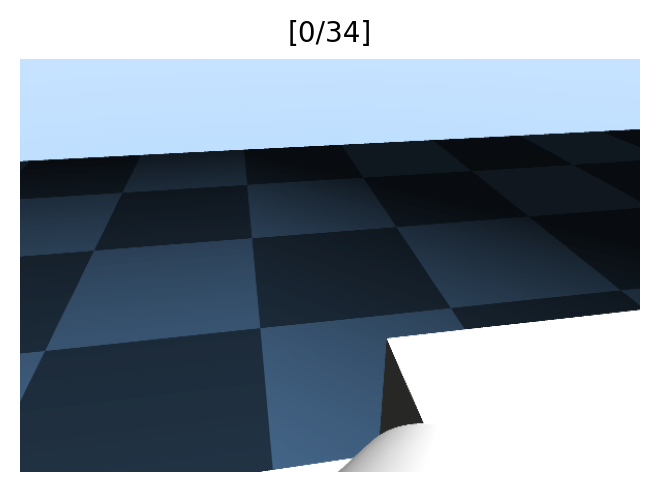

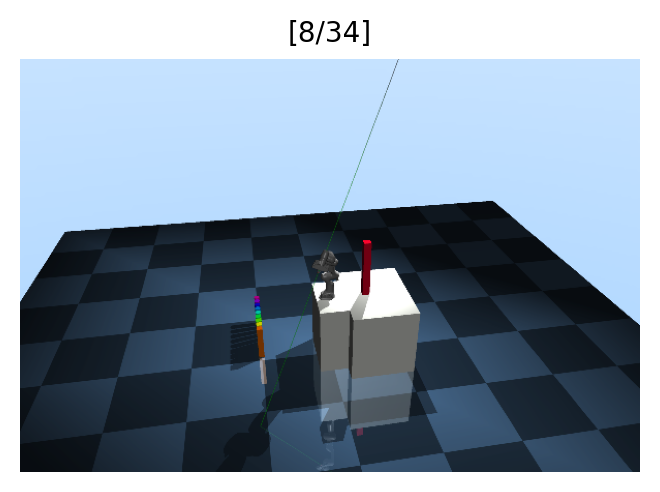

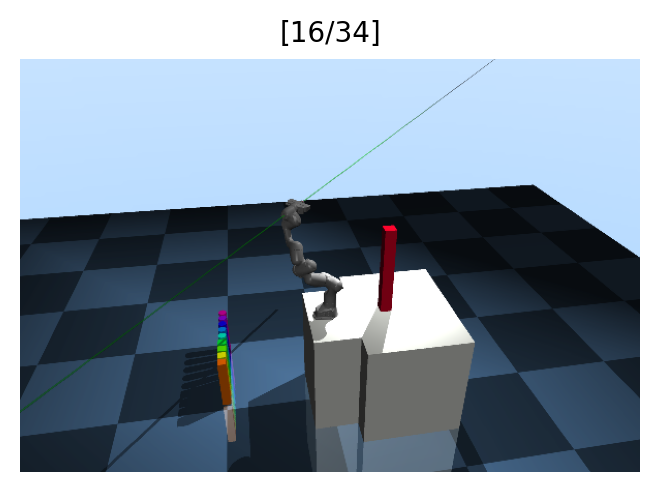

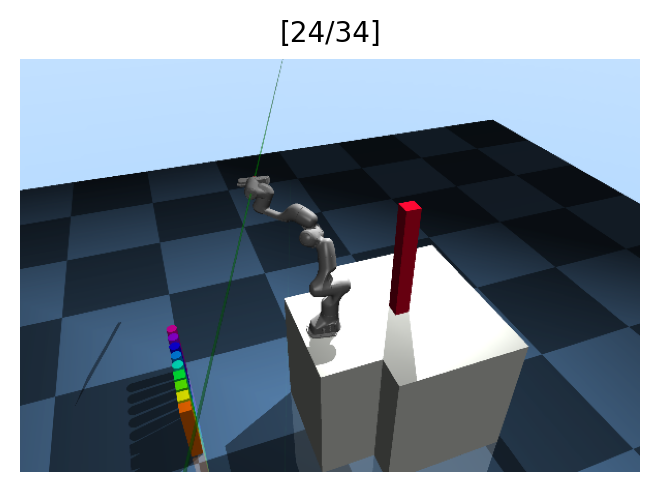

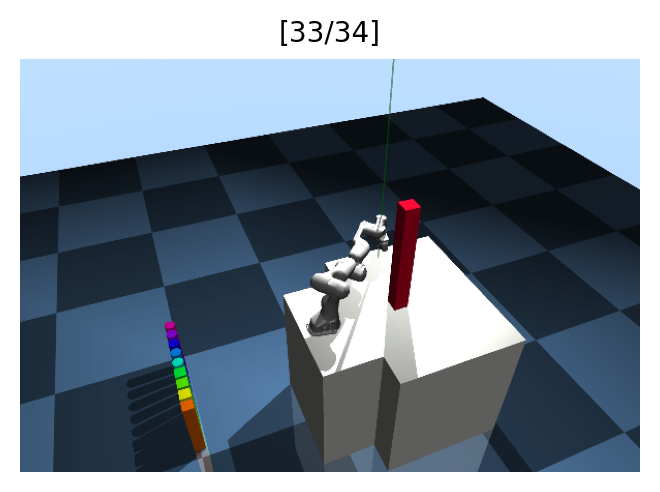

In [9]:
for i_idx in np.linspace(0,len(imgs)-1,5).astype(np.int32):
    plt.figure(figsize=(4,3))
    plt.imshow(cv2.resize(imgs[i_idx],(600,400)))
    plt.axis('off'); plt.title('[%d/%d]'%(i_idx,len(imgs)),fontsize=10); plt.show()

### Plot joint positions

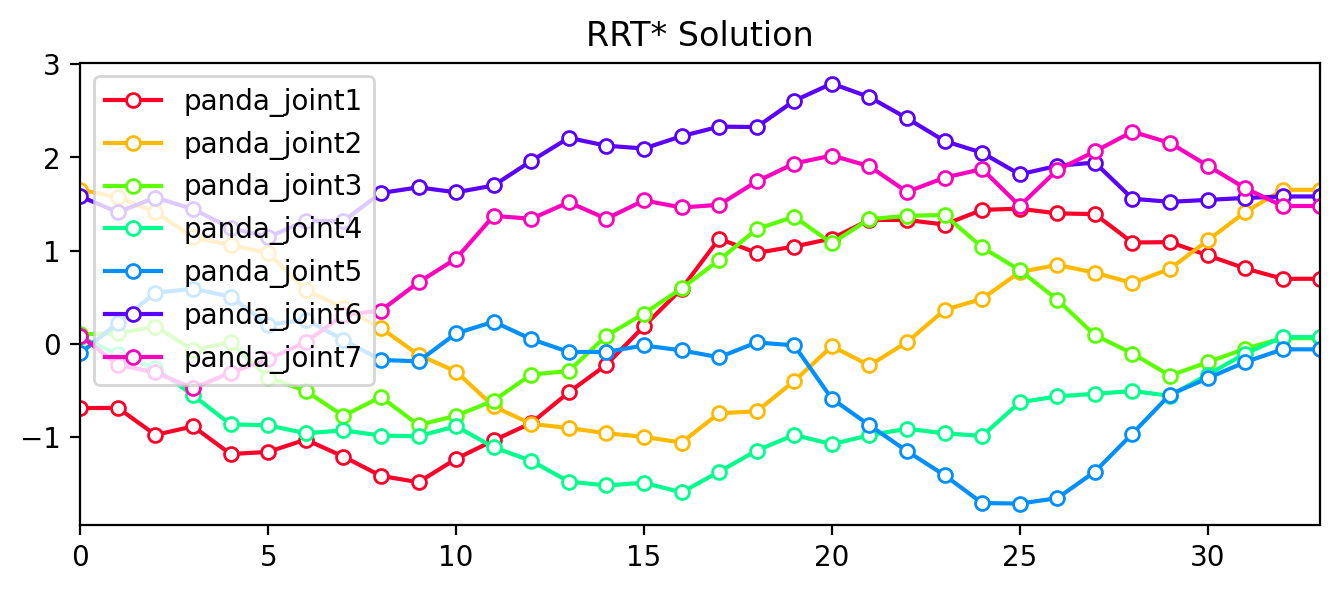

In [10]:
plt.figure(figsize=(8,3))
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,RRT.dim)])
for d_idx in range(RRT.dim):
    color=colors[d_idx,:]
    plt.plot(path_to_goal[:,d_idx],
             '-',marker='o',mec=color,mfc='w',ms=5,color=color,
             label='%s'%(env.rev_joint_names[d_idx]))
plt.title("RRT* Solution")    
plt.xlim(0,L-1); plt.legend(fontsize=10); plt.show()

### Compute `qs_interp`

In [11]:
# Configuration
qvel_rad = np.deg2rad(90) # desired joint velocity (deg/sec)
HZ = 100
times_interp,qs_interp = get_interp_const_vel_traj(path_to_goal,vel=qvel_rad,HZ=HZ,ord=np.inf)
L_interp = qs_interp.shape[0]
print ("qvel_deg:[%.2f]deg/sec L_interp:[%d] HZ:[%d] time_max:[%.2f]sec"%
       (np.rad2deg(qvel_rad),L_interp,HZ,times_interp[-1]))

qvel_deg:[90.00]deg/sec L_interp:[722] HZ:[100] time_max:[7.22]sec


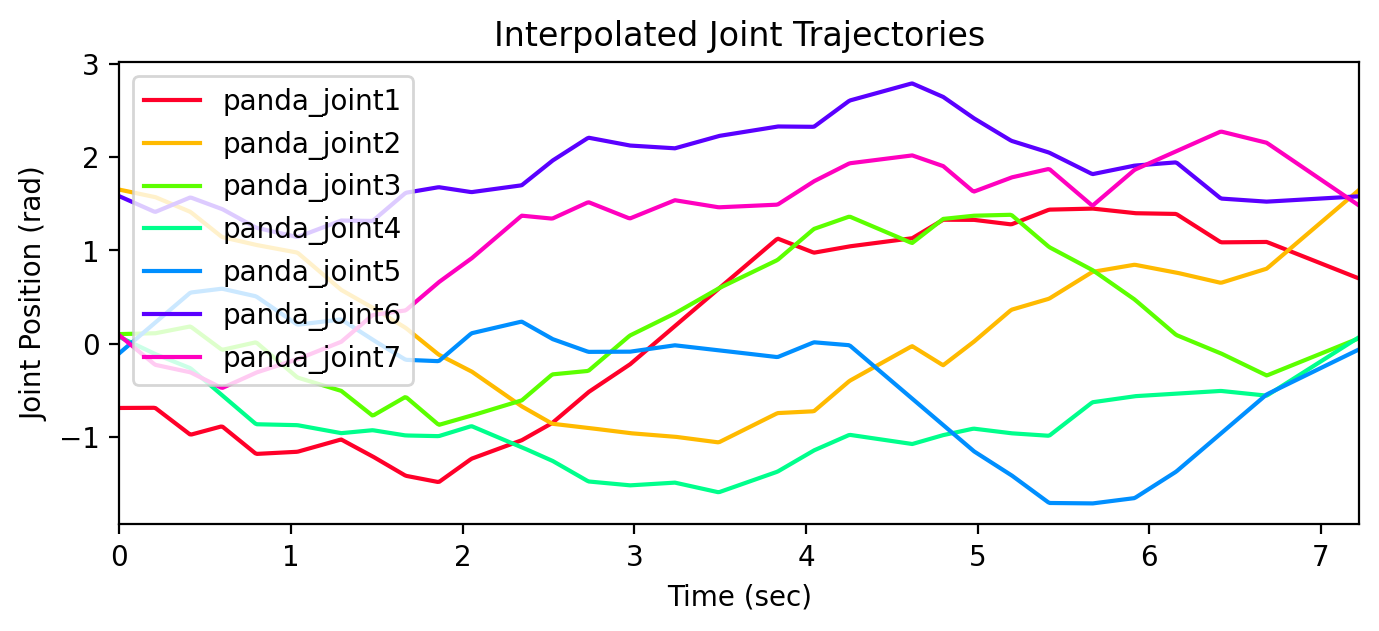

In [12]:
plt.figure(figsize=(8,3))
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,RRT.dim)])
for d_idx in range(RRT.dim):
    color=colors[d_idx,:]
    plt.plot(times_interp,qs_interp[:,d_idx],'-',color=color,
             label='%s'%(env.rev_joint_names[d_idx]))
plt.xlabel('Time (sec)'); plt.ylabel('Joint Position (rad)')
plt.title("Interpolated Joint Trajectories")
plt.xlim(0,times_interp[-1]); plt.legend(fontsize=10); plt.show()

### Animate interpolated RRT* solution (`times_interp` and `qs_interp`)

In [13]:
# Animate
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]))
env.reset()
for tick in range(L_interp):
    q = qs_interp[tick,:]
    env.forward(q=q,joint_idxs=env.rev_joint_idxs)
    env.render(); 
    if not env.is_viewer_alive(): break
for tick in range(500): # final pose animate
    env.render(); 
    if not env.is_viewer_alive(): break
env.close_viewer() # close viewer
print ("Done.")

Done.


### Smooth using `GRP`

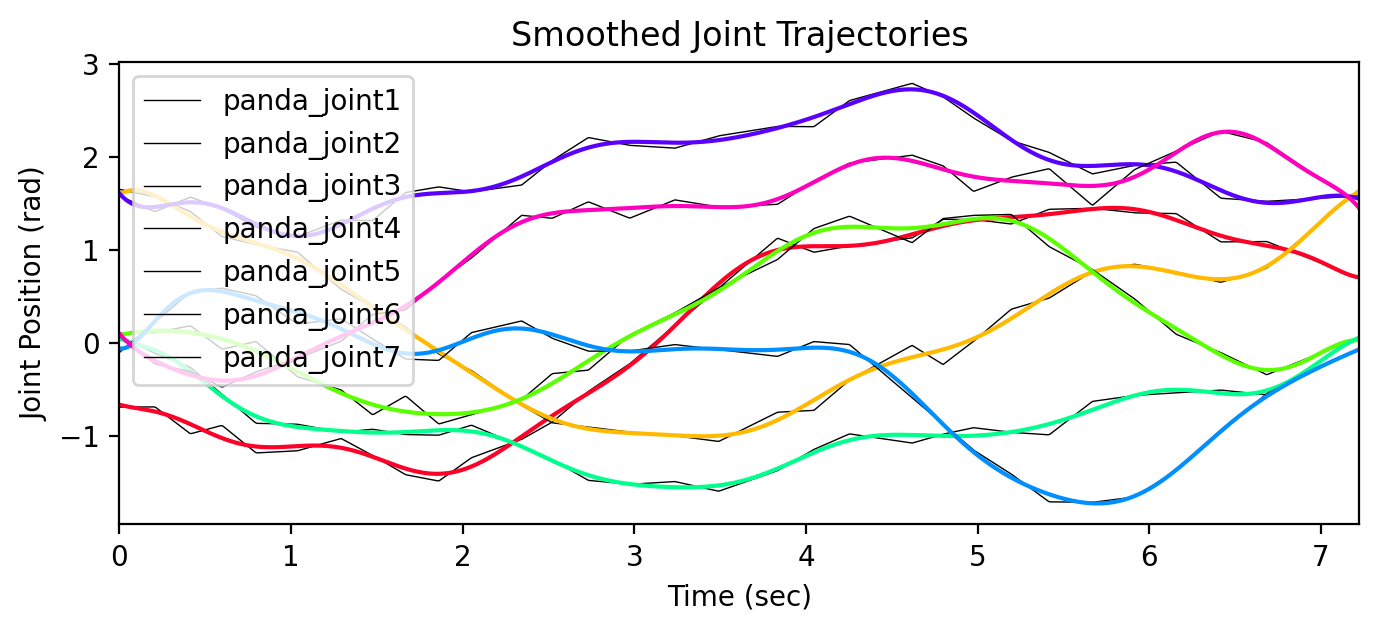

In [14]:
G = GaussianRandomPathClass(name='LGRP',kernel=kernel_levse)
G.set_data(t_anchor    = times_interp.reshape((-1,1)),
           x_anchor    = qs_interp,
           l_anchor    = np.ones((len(times_interp),1)),
           t_test      = times_interp.reshape((-1,1)),
           l_test      = np.ones((len(times_interp),1)),
           hyp_mean    = {'g':1.0,'l':1.0,'w':1e-6},
           hyp_var     = {'g':1.0,'l':1.0,'w':1e-6},
           APPLY_EPSRU = False
          )
qs_smooth = G.mean_test

plt.figure(figsize=(8,3))
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,RRT.dim)])
for d_idx in range(RRT.dim):
    color=colors[d_idx,:]
    plt.plot(times_interp,qs_interp[:,d_idx],'-',color='k',lw=1/2,
             label='%s'%(env.rev_joint_names[d_idx]))
    plt.plot(times_interp,qs_smooth[:,d_idx],'-',color=color)
plt.xlabel('Time (sec)'); plt.ylabel('Joint Position (rad)')
plt.title("Smoothed Joint Trajectories")
plt.xlim(0,times_interp[-1]); plt.legend(fontsize=10); plt.show()

### Animate smoothed trajectories

In [15]:
# Animate
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]))
env.reset()
for tick in range(L_interp):
    q = qs_smooth[tick,:]
    env.forward(q=q,joint_idxs=env.rev_joint_idxs)
    env.render(); 
    if not env.is_viewer_alive(): break
for tick in range(500): # final pose animate
    env.render(); 
    if not env.is_viewer_alive(): break
env.close_viewer() # close viewer
print ("Done.")

Pressed ESC
Quitting.
Done.
